# Reading dataset and combining tables

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import poisson
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

directory = 'C:/Users/99451/Desktop/MODEL/old/eng_champ'

dfs = []

# Define the columns you want to extract from each CSV file
columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'FTR', 'HST', 'AST', 'B365H', 'B365D', 'B365A']

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(directory, filename), on_bad_lines = 'skip', encoding='latin-1')
        df = df[columns_to_keep]
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
df.head(5)

Number of rows: 12505
Number of columns: 13


,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,FTR,HST,AST,B365H,B365D,B365A
0,10/08/02,Burnley,Brighton,1.0,3.0,0.0,1.0,A,7.0,8.0,1.800,3.25,4.000
1,10/08/02,Coventry,Sheffield United,2.0,1.0,2.0,1.0,H,5.0,10.0,1.727,3.50,4.000
2,10/08/02,Derby,Reading,3.0,0.0,0.0,0.0,H,10.0,2.0,1.533,3.50,5.500
3,10/08/02,Leicester,Watford,2.0,0.0,0.0,0.0,H,9.0,2.0,1.727,3.25,4.333
4,10/08/02,Millwall,Rotherham,0.0,6.0,0.0,2.0,A,3.0,7.0,1.444,3.75,6.500


# Adding Moving Average Columns

In [2]:
#Calculating Points Per Game for Home and Away Teams
df['HPTS'] = np.select([df['FTR'] == 'H', df['FTR'] == 'D', df['FTR'] == 'A'], [3, 1, 0], default=0)
df['APTS'] = np.select([df['FTR'] == 'H', df['FTR'] == 'D', df['FTR'] == 'A'], [0, 1, 3], default=0)

df['HPPG'] = df.groupby('HomeTeam')['HPTS'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['APPG'] = df.groupby('AwayTeam')['APTS'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['form_dif'] = df['HPPG'] - df['APPG'] #calculating form difference home points per game - away points per game

#Calculating scored and conceded goals
df['FTHGS'] = df.groupby('HomeTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['FTHGC'] = df.groupby('HomeTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['FTAGS'] = df.groupby('AwayTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['FTAGC'] = df.groupby('AwayTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

#Calculating scored and conceded goals for halftime
df['HTHGS'] = df.groupby('HomeTeam')['HTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['HTHGC'] = df.groupby('HomeTeam')['HTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['HTAGS'] = df.groupby('AwayTeam')['HTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['HTAGC'] = df.groupby('AwayTeam')['HTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

#Calculating shots on target for home/away
df['HSTS'] = df.groupby('HomeTeam')['HST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['HSTC'] = df.groupby('HomeTeam')['AST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['ASTS'] = df.groupby('AwayTeam')['AST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))
df['ASTC'] = df.groupby('AwayTeam')['HST'].transform(lambda x: x.rolling(5, min_periods=1).mean().shift(1))

df['st_dif'] = df['HSTS'] - df['ASTS']

#Calculating odds probabilities
total = 1 / df['B365H'] + 1 / df['B365D'] + 1 / df['B365A']

df['FTH'] = (1 / df['B365H']) / total
df['FTD'] = (1 / df['B365D']) / total
df['FTA'] = (1 / df['B365A']) / total
df['FTDA'] = df['FTD'] + df['FTA']

# Calculate the league-wide moving average for home_goals and away_goals
df['league_home_goals'] = df['FTHG'].rolling(50, min_periods=1).mean().shift(1)
df['league_away_goals'] = df['FTAG'].rolling(50, min_periods=1).mean().shift(1)

df['ht_league_home_goals'] = df['HTHG'].rolling(50, min_periods=1).mean().shift(1)
df['ht_league_away_goals'] = df['HTAG'].rolling(50, min_periods=1).mean().shift(1)

#Calculating Poisson Statistics for Full/Halftime
df['home_attack'] = df['FTHGS'] / df['league_home_goals']
df['home_defence'] = df['FTHGC'] / df['league_away_goals']
df['away_attack'] = df['FTAGS'] / df['league_away_goals']
df['away_defence'] = df['FTAGC'] / df['league_home_goals']

df['ht_home_attack'] = df['HTHGS'] / df['ht_league_home_goals']
df['ht_home_defence'] = df['HTHGC'] / df['ht_league_away_goals']
df['ht_away_attack'] = df['HTAGS'] / df['ht_league_away_goals']
df['ht_away_defence'] = df['HTAGC'] / df['ht_league_home_goals']

df['home_xg'] = df['home_attack'] * df['away_defence'] * df['league_home_goals']
df['away_xg'] = df['away_attack'] * df['home_defence'] * df['league_away_goals']

df['ht_home_xg'] = df['ht_home_attack'] * df['ht_away_defence'] * df['ht_league_home_goals']
df['ht_away_xg'] = df['ht_away_attack'] * df['ht_home_defence'] * df['ht_league_away_goals']

df.dropna(inplace = True)
df = df.reset_index(drop = True)

df['home_poisson'] = df['home_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['away_poisson'] = df['away_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['ht_home_poisson'] = df['ht_home_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['ht_away_poisson'] = df['ht_away_xg'].apply(lambda lmbda: np.nanargmax(
    [poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) 
    if not pd.isnull(lmbda) and any([poisson.pmf(k, lmbda) for k in range(int(lmbda * 2))]) else 0)

df['poisson_df'] = df['home_poisson'] - df['away_poisson']
df['ht_poisson_df'] = df['ht_home_poisson'] - df['ht_away_poisson']
df['FTRT'] = [1 if x == 'H' else 0 for x in df['FTR']]

#Removing unnessary columns
df.drop(['Date', 'FTHG', 'FTAG', 'B365H', 'B365D', 'B365A', 'HPTS', 'APTS', 'FTHGS', 'FTHGC', 'FTAGS', 'FTAGC',
            'FTD', 'FTA', 'league_home_goals', 'league_away_goals', 'home_attack', 'home_defence', 'FTDA',
            'away_attack', 'away_defence', 'home_xg', 'away_xg', 'HPPG', 'APPG', 'home_poisson', 'away_poisson',
            'HST', 'AST', 'HSTC', 'ASTC', 'HTHG', 'HTAG', 'FTR', 'HSTS', 'ASTS',
            'ht_league_home_goals', 'ht_league_away_goals', 'ht_home_attack', 'ht_home_defence', 'ht_away_attack',
            'ht_away_defence', 'ht_home_xg', 'ht_away_xg', 'ht_home_poisson', 'ht_away_poisson',
            'HTHGS', 'HTHGC', 'HTAGS', 'HTAGC'], axis = 1, inplace = True)

df[df['HomeTeam'] == 'Sunderland'].head(7)

,HomeTeam,AwayTeam,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT
517,Sunderland,Watford,-0.80,3.000000,0.519432,-1,-2,1
545,Sunderland,Crystal Palace,0.10,1.500000,0.519087,1,1,1
581,Sunderland,Reading,0.60,0.466667,0.426230,0,0,1
592,Sunderland,Ipswich,1.05,-1.700000,0.499040,1,0,1
620,Sunderland,Cardiff,1.60,-1.000000,0.520446,1,0,0
633,Sunderland,Walsall,2.40,2.000000,0.595745,2,0,1
642,Sunderland,Rotherham,2.20,2.800000,0.622844,2,1,0


# Applying Normalization for Certain Columns

In [3]:
# Columns to normalize
cols_to_normalize = ['form_dif', 'st_dif', 'poisson_df', 'ht_poisson_df']

# Min-max normalization
df[cols_to_normalize] = df[cols_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df[df['HomeTeam'] == 'Sunderland'].head(7)

,HomeTeam,AwayTeam,form_dif,st_dif,FTH,poisson_df,ht_poisson_df,FTRT
517,Sunderland,Watford,0.366667,0.631579,0.519432,0.50,0.272727,1
545,Sunderland,Crystal Palace,0.516667,0.552632,0.519087,0.60,0.545455,1
581,Sunderland,Reading,0.600000,0.498246,0.426230,0.55,0.454545,1
592,Sunderland,Ipswich,0.675000,0.384211,0.499040,0.60,0.454545,1
620,Sunderland,Cardiff,0.766667,0.421053,0.520446,0.60,0.454545,0
633,Sunderland,Walsall,0.900000,0.578947,0.595745,0.65,0.454545,1
642,Sunderland,Rotherham,0.866667,0.621053,0.622844,0.65,0.545455,0


# Starting ML Tests with Random Forests


Random Forest - Training Accuracy: 0.7619959677419355
Random Forest - Test Accuracy: 0.5721774193548387


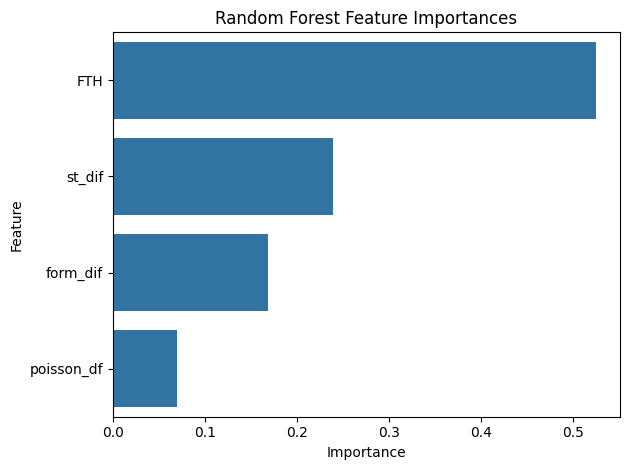

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      1378
           1       0.52      0.52      0.52      1102

    accuracy                           0.57      2480
   macro avg       0.57      0.57      0.57      2480
weighted avg       0.57      0.57      0.57      2480

Confusion Matrix:
[[851 527]
 [534 568]]
ROC AUC Score: 0.5664940904385481


In [4]:
# Split the data into training and testing sets
X = df.drop(columns=['FTRT', 'HomeTeam', 'AwayTeam', 'ht_poisson_df'], axis = 1)  # Features
y = df['FTRT']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Random Forest
rf_model = BalancedRandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, min_samples_leaf=10, random_state=42,
                                          sampling_strategy = 'all', replacement = True, bootstrap = False)

# Train models
rf_model.fit(X_train, y_train)

# Predictions
rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)

# Accuracy scores
rf_train_accuracy = accuracy_score(y_train, rf_train_preds)
rf_test_accuracy = accuracy_score(y_test, rf_test_preds)

print("\nRandom Forest - Training Accuracy:", rf_train_accuracy)
print("Random Forest - Test Accuracy:", rf_test_accuracy)

rf_feature_importances = rf_model.feature_importances_

# Visualize feature importances
rf_feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importances})

sns.barplot(x='Importance', y='Feature', data=rf_feature_importances_df.sort_values(by='Importance', ascending=False))
plt.title('Random Forest Feature Importances')

plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(y_test, rf_test_preds))

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(y_test, rf_test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, rf_test_preds)
print("ROC AUC Score:", roc_auc)

# Trying with Different Models

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Define models and their hyperparameter grids
models_and_parameters = {
    'Logistic Regression': (
        LogisticRegression(solver='liblinear'),
        {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}
    ),
    'Random Forest': (
        RandomForestClassifier(),
        {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
    ),
    'Support Vector Machine': (
        SVC(probability=True),
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    ),
    'Naive Bayes': (
        GaussianNB(),
        {}  # No hyperparameters to tune in basic GaussianNB
    ),
    'Gradient Boosting': (
        GradientBoostingClassifier(),
        {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(),
        {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
    ),
    'k-Nearest Neighbors': (
        KNeighborsClassifier(),
        {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    )
}

# Store results
grid_search_results = {}

for name, (model, param_grid) in models_and_parameters.items():
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1  # Use all available cores
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_preds = best_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    test_accuracy = accuracy_score(y_test, y_preds)
    
    grid_search_results[name] = {
        'best_params': grid_search.best_params_,
        'roc_auc': roc_auc,
        'accuracy': test_accuracy
    }

# Print results
print("\n📊 ROC AUC Scores and Best Parameters:")
for name, result in grid_search_results.items():
    print(f"{name}: Test Accuracy = {result['accuracy']:.4f} | Best Params: {result['best_params']}")


Running GridSearchCV for Logistic Regression...
Running GridSearchCV for Random Forest...
Running GridSearchCV for Support Vector Machine...
Running GridSearchCV for Naive Bayes...
Running GridSearchCV for Gradient Boosting...
Running GridSearchCV for Decision Tree...
Running GridSearchCV for k-Nearest Neighbors...

📊 ROC AUC Scores and Best Parameters:
Logistic Regression: Test Accuracy = 0.6016 | Best Params: {'C': 1, 'penalty': 'l1'}
Random Forest: Test Accuracy = 0.5952 | Best Params: {'max_depth': 10, 'n_estimators': 200}
Support Vector Machine: Test Accuracy = 0.6004 | Best Params: {'C': 10, 'kernel': 'rbf'}
Naive Bayes: Test Accuracy = 0.5960 | Best Params: {}
Gradient Boosting: Test Accuracy = 0.6044 | Best Params: {'learning_rate': 0.01, 'n_estimators': 200}
Decision Tree: Test Accuracy = 0.5935 | Best Params: {'max_depth': 10, 'min_samples_split': 5}
k-Nearest Neighbors: Test Accuracy = 0.5548 | Best Params: {'n_neighbors': 7, 'weights': 'uniform'}


# Trying with Best Model (Support Vector Machine)


✅ ROC AUC Score: 0.6246

✅ Test Accuracy: 0.6000

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.84      0.70      1378
           1       0.60      0.29      0.40      1102

    accuracy                           0.60      2480
   macro avg       0.60      0.57      0.55      2480
weighted avg       0.60      0.60      0.57      2480


🧩 Confusion Matrix:
[[1164  214]
 [ 778  324]]


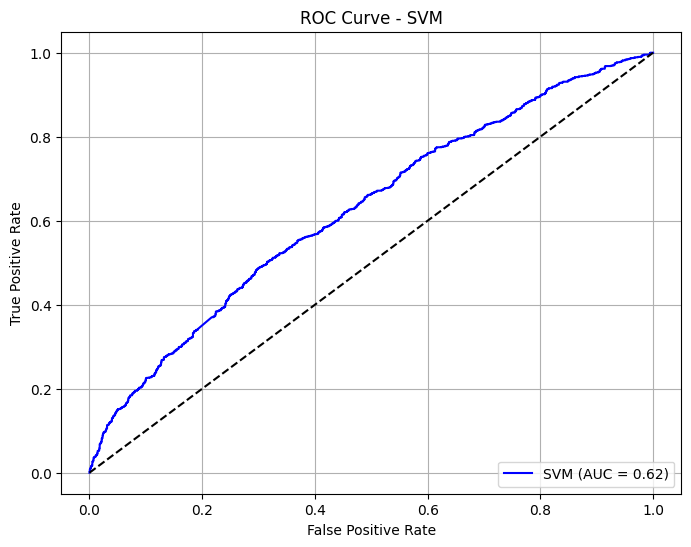

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Train the best SVM model
best_svm = SVC(C=1, kernel='linear', probability=True)
best_svm.fit(X_train, y_train)

# Predict probabilities and classes
y_pred_proba = best_svm.predict_proba(X_test)[:, 1]
y_pred = best_svm.predict(X_test)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ ROC AUC Score: {roc_auc:.4f}")
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

# Classification report
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Trying with 2nd Best Model (Logistic Regression)

ROC AUC Score: 0.6243411504086778

✅ Test Accuracy: 0.5899
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.62      1378
           1       0.54      0.56      0.55      1102

    accuracy                           0.59      2480
   macro avg       0.59      0.59      0.59      2480
weighted avg       0.59      0.59      0.59      2480



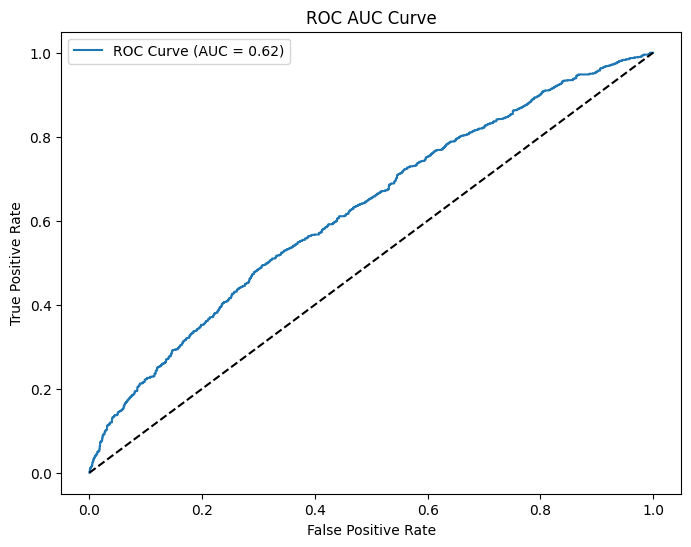

[[843 535]
 [482 620]]


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# Initialize and train Logistic Regression model with best hyperparameters
logistic_regression = LogisticRegression(C=10, class_weight='balanced', penalty='l1', solver='liblinear')
logistic_regression.fit(X_train, y_train)

# Generate predictions on the test set
y_pred_proba = logistic_regression.predict_proba(X_test)[:, 1]
y_pred = logistic_regression.predict(X_test)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

# Generate classification report
y_pred = logistic_regression.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC AUC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.show()

print(confusion_matrix(y_test, y_pred))